# PO - Head and Neck Cancer Classifiers and Regressors

## Pre Code

In [ ]:
!pip install catboost

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',None)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler,OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import roc_auc_score ,mean_squared_error,r2_score,accuracy_score,roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier 
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB

#Regressors
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR
import lightgbm as lgb
import catboost as cb

import graphviz

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = "/content/drive/Shareddrives/Precision Oncology Green Group/Project Data/pooled_data.csv"
data = pd.read_csv(data)

## main code

### Data Preprocesing

In [ ]:
df = data.loc[:,['TCIA code','Sex', 'Age','Height (m)', 'BMI start treat (kg/m2)', 'Diag','Grade','HPV status',
       'Induction Chemotherapy', 'Chemotherapy Regimen',
       'Platinum-based chemotherapy', 'Received Concurrent Chemoradiotherapy?',
       'CCRT Chemotherapy Regimen', 'Surgery Summary', 'Smoking History',
       'Current Smoker', 'Stage', 'Alive or Dead', 'Site of recurrence (Distal/Local/ Locoregional)',
       'Survival  (months)', 'Total RT treatment time (days)']]
df.head()

,TCIA code,Sex,Age,Height (m),BMI start treat (kg/m2),Diag,Grade,HPV status,Induction Chemotherapy,Chemotherapy Regimen,Platinum-based chemotherapy,Received Concurrent Chemoradiotherapy?,CCRT Chemotherapy Regimen,Surgery Summary,Smoking History,Current Smoker,Stage,Alive or Dead,Site of recurrence (Distal/Local/ Locoregional),Survival (months),Total RT treatment time (days)
0,HNSCC-01-0001,Female,54,1.685,19.618030,CA soft palate,moderately to poorly diff.,NaN,No,Cisplatin q 3 weeks,Platinum-based,Yes,Cisplatin high dose,No,0,0,IVA,Alive,Complete response,99.600000,43
1,HNSCC-01-0002,Female,56,1.660,21.229496,NPC,moderately diff.,NaN,No,Cisplatin weekly,Platinum-based,Yes,Cisplatin weekly,No,2,1,IVA,Dead,Recurrence,42.016438,43
2,HNSCC-01-0003,Male,48,1.780,29.604848,CA tonsil,moderately diff.,NaN,No,Cisplatin weekly,Platinum-based,Yes,Cisplatin weekly,No,2,1,IVA,Alive,Complete response,61.133333,37
3,HNSCC-01-0004,Male,65,1.750,24.783673,CA tonsil,poorly diff.,NaN,No,Cisplatin weekly,Platinum-based,Yes,Cisplatin weekly,No,1,0,IVA,Dead,Recurrence,13.433333,45
4,HNSCC-01-0005,Male,66,1.670,33.633332,CA tonsil,moderately diff.,NaN,No,No,No,No,No,No,2,1,III,Alive,Recurrence,110.266667,43


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 21 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   TCIA code                                        215 non-null    object 
 1   Sex                                              215 non-null    object 
 2   Age                                              215 non-null    int64  
 3   Height (m)                                       215 non-null    float64
 4   BMI start treat (kg/m2)                          215 non-null    float64
 5   Diag                                             215 non-null    object 
 6   Grade                                            215 non-null    object 
 7   HPV status                                       47 non-null     object 
 8   Induction Chemotherapy                           214 non-null    object 
 9   Chemotherapy Regimen            

In [ ]:
# df.describe()

In [ ]:
#HPV status

df['HPV status'] = df['HPV status'].fillna("unknown")

In [ ]:
# #Duration of Pre and Post RT Images

# df['Pre-RT Imaging Date'] = pd.to_datetime(df['Pre-RT Imaging Date'], format='%d/%m/%Y')
# df['post-RT imaging date'] = pd.to_datetime(df['post-RT imaging date'], format='%d/%m/%Y')

# df['Duration of Pre and Post RT Images'] = (df['post-RT imaging date'] - df['Pre-RT Imaging Date']).dt.days

# df = df.drop(columns = ['Pre-RT Imaging Date','post-RT imaging date'])

# Pre_post_col = df.pop('Duration of Pre and Post RT Images')
# df.insert(45,'Duration of Pre and Post RT Images',Pre_post_col)

In [ ]:
#Surgery Summary

df['Surgery Summary'].unique()

df['Surgery Summary'] = df['Surgery Summary'].replace(['Modified left radical neck dissection',
       'Neck node dissection', 'Tonsillectomy + Radical neck dissection',
       'Right total mandibulectomy + Partial pharyngectomy + Neck dissection',
       'Wide local excision + reconstruction + Neck dissection',
       '1) Tonsillectomy 2) Neck node dissection',
       'Tonsillectomy + Neck node dissection',
       'Hemiglossectomy + Mandibulectomy + Neck node  dissection',
       'Bilateral tonsillectomy',
       'Total glossectomy + Total laryngectomy + Reconstruction',
       'Thyroidectomy + Neck node dissection',
       'Salvage tonsillectomy + Neck node dissection', 'Tonsillectomy',
       '1)Neck node dissection 2) Salvage tonsillectomy',
       'S/P Maxillectomy', '1) Laryngectomy 2) Neck node dissection',
       'Maxillectomy', 'Total pharyngolaryngectomy',
       'Excision + Neck node dissection',
       'Total laryngectomy + Neck node dissection',
       'Total laryngectomy + Neck node dissection + Thyroid lobectomy etc.'], 'Other Surgeries')

In [ ]:
#Induction Chemotherapy

df['Induction Chemotherapy'].unique()

df['Induction Chemotherapy'] = df['Induction Chemotherapy'].replace(['Carbo + Taxol x 2 cycles',
       'Carboplatin + Taxol  + Ifosfamide x 3 cycles',
       'Carbo + Taxol x 4 cycles', 'Carbo + Taxol x 3 cycles',
       'Carboplatin + Taxol  + Cetuximab',
       'Cisplatin + Docetaxel x 2 cycles + Cetuximab',
       'Carboplatin + Taxol', 'Cisplatin + Docetaxel x 3 cycles',
       'Carboplatin + Docetaxol + 5-FU x 1 cycle',
       'Carboplatin + Taxol x 6 cycles', 'Cisplatin + Docetaxel',
       'Cisplatin + 5-FU + Docetaxel x 1 cycle',
       'Cisplatin + 5-FU + Docetaxel x 3 cycles', 'Carboplatin+ Taxol',
       'Cisplatin + 5-FU + Docetaxel x 4 cycles',
       'Cisplatin + 5-FU + Docetaxel x 2 cycles',
       'Carboplatin + Taxol x 5 cycles',
       'Carboplatin + Docetaxel x 3 cycles',
       'Cisplatin + Doxetaxel x 2 cycles',
       'Carboplatin + 5-FU + Docetaxel x 3 cycles',
       'Carboplatin + Taxol x 3 cycles', 'Carboplatin + Taxol weekly',
       'Carboplatin + Docetaxel', 'Cisplatin + Docetaxel x 2 cycles',
       'Cisplatin + Docetaxel x 1 cycle then Carboplatin _ Taxol x 2 cycles',
       'Carboplatin + Taxol x 2 cycles',
       'Carboplatin + Doxetacel x 2 cycles',
       'Carboplatin + 5-FU + Docetaxel x 2 cycles --> Carboplatin + Docetaxel x 1 cycle',
       'Carboplatin + Taxol + Cetuximab'], 'Yes')

In [ ]:
# Site of recurrence (Distal/Local/ Locoregional)

df['Site of recurrence (Distal/Local/ Locoregional)'].unique()

df['Site of recurrence (Distal/Local/ Locoregional)'] = df['Site of recurrence (Distal/Local/ Locoregional)'].replace([
      'Local recurrence', 'Distant metastasis',
       'Locoregional and distant metastasis', 'Residual tumor',
       'Regional recurrence',
       'Regional recurrence and distant metasatsis',
       'Local recurrence and distant metastasis',
       'Regional and distant metastasis', 'Locoregional recurrence'], 'No')


df = df.rename(columns={'Site of recurrence (Distal/Local/ Locoregional)': 'Response or Recurrence'})

In [ ]:
# Finding the total missing values and arranging them in ascending order
total = df.isnull().sum()

# Converting the missing values in percentage
percent = (df.isnull().sum()/df.isnull().count())

# df.head()

In [ ]:
# dropping features having missing values more than 60%
df = df.drop((percent[percent > 0.6]).index,axis= 1)

# checking null values
# print(df.isnull().sum())

In [ ]:
print('Shape of the data is: ',df.shape)

Shape of the data is:  (215, 21)


In [ ]:
# df = df.drop(columns ="TCIA code")

X = df.iloc[:,1:16]  # Features

Y = df.iloc[:,17:]   # Target Values

In [ ]:
# IDENTIFYING NUMERICAL FEATURES

numeric_data = X.select_dtypes(include=np.number) # select_dtypes selects data with numeric features
numeric_col = numeric_data.columns                                                                # we will store the numeric features in a variable

print("Numeric Features:")
numeric_data.head()
# print("===="*20)

Numeric Features:


,Age,Height (m),BMI start treat (kg/m2),Smoking History,Current Smoker
0,54,1.685,19.618030,0,0
1,56,1.660,21.229496,2,1
2,48,1.780,29.604848,2,1
3,65,1.750,24.783673,1,0
4,66,1.670,33.633332,2,1


In [ ]:
# IDENTIFYING CATEGORICAL FEATURES
categorical_data = X.select_dtypes(exclude=np.number) # we will exclude data with numeric features
categorical_col = categorical_data.columns                                                                              # we will store the categorical features in a variable


print("Categorical Features:")
categorical_data.head()
# print("===="*20)

Categorical Features:


,Sex,Diag,Grade,HPV status,Induction Chemotherapy,Chemotherapy Regimen,Platinum-based chemotherapy,Received Concurrent Chemoradiotherapy?,CCRT Chemotherapy Regimen,Surgery Summary
0,Female,CA soft palate,moderately to poorly diff.,unknown,No,Cisplatin q 3 weeks,Platinum-based,Yes,Cisplatin high dose,No
1,Female,NPC,moderately diff.,unknown,No,Cisplatin weekly,Platinum-based,Yes,Cisplatin weekly,No
2,Male,CA tonsil,moderately diff.,unknown,No,Cisplatin weekly,Platinum-based,Yes,Cisplatin weekly,No
3,Male,CA tonsil,poorly diff.,unknown,No,Cisplatin weekly,Platinum-based,Yes,Cisplatin weekly,No
4,Male,CA tonsil,moderately diff.,unknown,No,No,No,No,No,No


In [ ]:
X[categorical_col].head()

,Sex,Diag,Grade,HPV status,Induction Chemotherapy,Chemotherapy Regimen,Platinum-based chemotherapy,Received Concurrent Chemoradiotherapy?,CCRT Chemotherapy Regimen,Surgery Summary
0,Female,CA soft palate,moderately to poorly diff.,unknown,No,Cisplatin q 3 weeks,Platinum-based,Yes,Cisplatin high dose,No
1,Female,NPC,moderately diff.,unknown,No,Cisplatin weekly,Platinum-based,Yes,Cisplatin weekly,No
2,Male,CA tonsil,moderately diff.,unknown,No,Cisplatin weekly,Platinum-based,Yes,Cisplatin weekly,No
3,Male,CA tonsil,poorly diff.,unknown,No,Cisplatin weekly,Platinum-based,Yes,Cisplatin weekly,No
4,Male,CA tonsil,moderately diff.,unknown,No,No,No,No,No,No


In [ ]:
# imputing missing values with mean

for column in numeric_col:
    mean = X[column].mean()
    X[column].fillna(mean,inplace = True)

In [ ]:
# Impute mising values of categorical data with mode
for column in categorical_col:
    mode = X[column].mode()[0]
    X[column] = X[column].replace('unknown',mode)

In [ ]:
#Filtered Data
# df.to_csv("/content/drive/Shareddrives/Precision Oncology Green Group/Project Data/new_filtered data.csv")

### Classifiers

In [ ]:
# we are finding the percentage of each class in the feature 'y'

class_values_1 = (Y['Response or Recurrence'].value_counts()/Y['Response or Recurrence'].value_counts().sum())*100
print(class_values_1)

Complete response    66.976744
Recurrence           33.023256
Name: Response or Recurrence, dtype: float64


In [ ]:
# we are finding the percentage of each class in the feature 'y'

class_values_2 = (Y['Alive or Dead'].value_counts()/Y['Alive or Dead'].value_counts().sum())*100
print(class_values_2)

Alive    64.186047
Dead     35.813953
Name: Alive or Dead, dtype: float64


In [ ]:
# preprocessor = ColumnTransformer(transformers=[
#         # ('num_features', StandardScaler(), numeric_col),
#         ('cat_features', LabelEncoder(), categorical_col)
# ])

In [ ]:
# # Initializing lable encoder
# le = LabelEncoder()

# # Initializing Label Encoder
# le = LabelEncoder()

# # Iterating through each of the categorical columns and label encoding them
# for feature in categorical_col:
#     try:
#         df[feature] = le.fit_transform(df[feature])
#     except:
#         print('Error encoding '+feature)

In [ ]:
# df.head()

### Classifier 1 - Response or Recurrence

In [ ]:
# Predictors

# X = df.iloc[:,0:15]
# X = X.drop(columns ="TCIA code")
# Target
y = Y['Response or Recurrence']

# Dividing the data into train and test subsets
x_train,x_val,y_train,y_val = train_test_split(X,y,test_size=0.3,random_state=42)

In [ ]:
# Create a LabelEncoder instance
le = LabelEncoder()

# Fit and transform the target variable
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

#### Vanilla models when training with 15 features

In [ ]:
classifiers = [
    ('Logistic Regression', LogisticRegression()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('Support Vector Machine', SVC()),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('XGBoost Classifier', XGBClassifier()),
    ('Bagging Classifier', BaggingClassifier())
]

In [ ]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_col),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_col)
],
sparse_threshold=0)

In [ ]:
model_scores = {}

for name, classifier in classifiers:
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', classifier)])
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_val)
    
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')
    
    model_scores[name] = (accuracy, f1)
    print(f'{name}: Accuracy = {accuracy:.2f}, F1 Score = {f1:.2f}')

Logistic Regression: Accuracy = 0.80, F1 Score = 0.79
Decision Tree: Accuracy = 0.66, F1 Score = 0.67
Random Forest: Accuracy = 0.65, F1 Score = 0.60
Gradient Boosting: Accuracy = 0.77, F1 Score = 0.74
Support Vector Machine: Accuracy = 0.72, F1 Score = 0.65
K-Nearest Neighbors: Accuracy = 0.71, F1 Score = 0.69
Naive Bayes: Accuracy = 0.28, F1 Score = 0.17
XGBoost Classifier: Accuracy = 0.71, F1 Score = 0.67
Bagging Classifier: Accuracy = 0.68, F1 Score = 0.64


Based on the results achieved, the performance of the classification models varies. The XGBoost Classifier seems to perform the best, with the highest accuracy (0.71) and F1 score (0.66). While an accuracy of 0.71 is not perfect, it's a good start, and the model could potentially be improved further with hyperparameter tuning, feature engineering, or more data.

The F1 score is a measure of a model's accuracy considering both precision and recall, and it is especially useful when there is an uneven class distribution. The XGBoost Classifier has the highest F1 score, which means it performs better than the other models in terms of precision and recall.

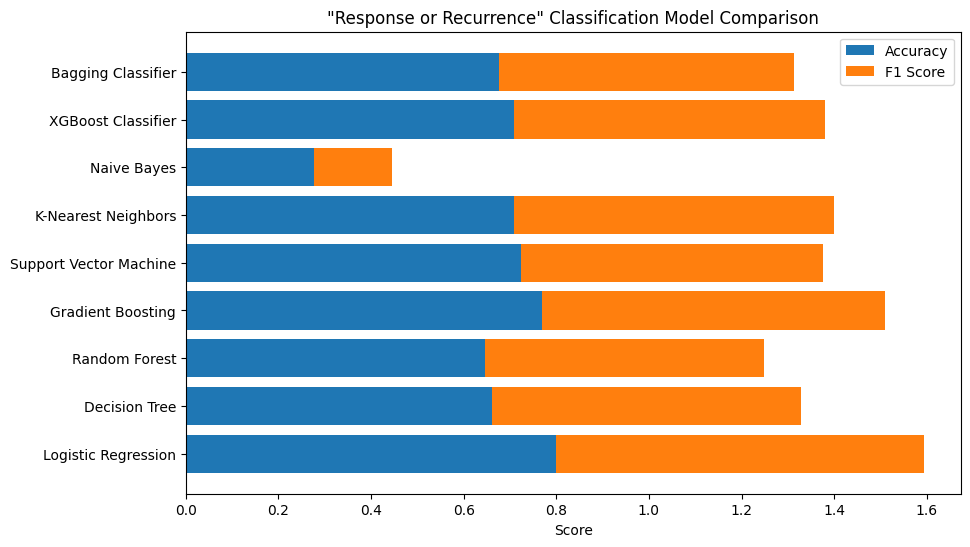

In [ ]:
# Plot the comparison of models
fig, ax = plt.subplots(figsize=(10, 6))

models = list(model_scores.keys())
accuracy_values = [model_scores[model][0] for model in models]
f1_values = [model_scores[model][1] for model in models]

ax.barh(models, accuracy_values, label='Accuracy')
ax.barh(models, f1_values, left=accuracy_values, label='F1 Score')

ax.set_xlabel('Score')
ax.set_title('"Response or Recurrence" Classification Model Comparison')
ax.legend()

plt.show()

#### Hyperparameter tuning for Logistic Regression and Gradient Boosting 

In [ ]:
# Hyperparameter tuning for Logistic Regression
lr_param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression())])
lr_grid_search = GridSearchCV(lr_pipeline, lr_param_grid, scoring='accuracy', cv=5, n_jobs=-1)
lr_grid_search.fit(x_train, y_train)

print("Logistic Regression: Best Parameters =", lr_grid_search.best_params_)

lr_best_params = {key.replace('classifier__', ''): value for key, value in lr_grid_search.best_params_.items()}
lr_best = LogisticRegression(**lr_best_params)
lr_best_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', lr_best)])
lr_best_pipeline.fit(x_train, y_train)
y_pred_lr = lr_best_pipeline.predict(x_val)

lr_accuracy = accuracy_score(y_val, y_pred_lr)
lr_f1 = f1_score(y_val, y_pred_lr, average='weighted')
print(f'Logistic Regression: Accuracy = {lr_accuracy:.2f}, F1 Score = {lr_f1:.2f}')

print("\n=============================================================================================================================\n")
# Hyperparameter tuning for Gradient Boosting
gb_param_grid = {
    'classifier__n_estimators': [10, 50, 100, 200],
    'classifier__learning_rate': [0.001, 0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5, 6, 7]
}

gb_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', GradientBoostingClassifier())])
gb_grid_search = GridSearchCV(gb_pipeline, gb_param_grid, scoring='accuracy', cv=5, n_jobs=-1)
gb_grid_search.fit(x_train, y_train)

print("Gradient Boosting: Best Parameters =", gb_grid_search.best_params_)

gb_best_params = {key.replace('classifier__', ''): value for key, value in gb_grid_search.best_params_.items()}
gb_best = GradientBoostingClassifier(**gb_best_params)
gb_best_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', gb_best)])
gb_best_pipeline.fit(x_train, y_train)
y_pred_gb = gb_best_pipeline.predict(x_val)

gb_accuracy = accuracy_score(y_val, y_pred_gb)
gb_f1 = f1_score(y_val, y_pred_gb, average='weighted')
print(f'Gradient Boosting: Accuracy = {gb_accuracy:.2f}, F1 Score = {gb_f1:.2f}')


Logistic Regression: Best Parameters = {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Logistic Regression: Accuracy = 0.75, F1 Score = 0.74


Gradient Boosting: Best Parameters = {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 50}
Gradient Boosting: Accuracy = 0.72, F1 Score = 0.61


In [ ]:
# Add the following code at the end to save the XGBoost model
best_model_name = 'LogisticRegression'
best_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', LogisticRegression())])
best_pipeline.fit(x_train, y_train)

# Save the best model as a pickle file
with open('Reccurance_logistic.pkl', 'wb') as file:
    pickle.dump(best_pipeline, file)
    


#### Models with feature selection

In [ ]:
# Selecting 5 number of features
#   selecting models

logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
#   using  rfe and selecting 5 features
rfe = RFE(logreg,n_features_to_select=5)
#   fitting the model
rfe = rfe.fit(X,y)
#   ranking features
logreg_feature_ranking = pd.Series(rfe.ranking_, index=X.columns)
plt.show()
print('Features  to be selected for Logistic Regression model are:')
print(logreg_feature_ranking[logreg_feature_ranking.values==1].index.tolist())
print('===='*30)


rfc = RandomForestClassifier()
#   using  rfe and selecting 5 features
rfe = RFE(rfc,n_features_to_select=5)
#   fitting the model
rfe = rfe.fit(X,y)
#   ranking features
rfc_feature_ranking = pd.Series(rfe.ranking_, index=X.columns)
plt.show()
print('Features  to be selected for Random Forest Classifier model are:')
print(rfc_feature_ranking[rfc_feature_ranking.values==1].index.tolist())
print('===='*30)


dtc = DecisionTreeClassifier()
#   using  rfe and selecting 5 features
rfe = RFE(dtc,n_features_to_select=5)
#   fitting the model
rfe = rfe.fit(X,y)
#   ranking features
dtc_feature_ranking = pd.Series(rfe.ranking_, index=X.columns)
plt.show()
print('Features  to be selected for Decision Tree Classifier model are:')
print(dtc_feature_ranking[dtc_feature_ranking.values==1].index.tolist())
print('===='*30)

gbc = GradientBoostingClassifier()
#   using  rfe and selecting 5 features
rfe = RFE(gbc,n_features_to_select=5)
#   fitting the model
rfe = rfe.fit(X,y)
#   ranking features
gbc_feature_ranking = pd.Series(rfe.ranking_, index=X.columns)
plt.show()
print('Features  to be selected for Gradient Boosting Classifier model are:')
print(gbc_feature_ranking[gbc_feature_ranking.values==1].index.tolist())
print('===='*30)


# svc = SVC()
# #   using  rfe and selecting 30 features
# rfe = RFE(svc,n_features_to_select=5)
# #   fitting the model
# rfe = rfe.fit(X,y)
# #   ranking features
# svc_feature_ranking = pd.Series(rfe.ranking_, index=X.columns)
# plt.show()
# print('Features  to be selected for Support Vector Machine Classifier model are:')
# print(svc_feature_ranking[svc_feature_ranking.values==1].index.tolist())
# print('===='*30)

# knn = KNeighborsClassifier()
# #   using  rfe and selecting 30 features
# rfe = RFE(knn,n_features_to_select=5)
# #   fitting the model
# rfe = rfe.fit(X,y)
# #   ranking features
# knn_feature_ranking = pd.Series(rfe.ranking_, index=X.columns)
# plt.show()
# print('Features  to be selected for K-Nearest Neighbors Classifier model are:')
# print(knn_feature_ranking[knn_feature_ranking.values==1].index.tolist())
# print('===='*30)

xgbc = XGBClassifier()
#   using  rfe and selecting 30 features
rfe = RFE(xgbc,n_features_to_select=5)
#   fitting the model
rfe = rfe.fit(X,y)
#   ranking features
xgbc_feature_ranking = pd.Series(rfe.ranking_, index=X.columns)
plt.show()
print('Features  to be selected for XGBoost Classifier model are:')
print(xgbc_feature_ranking[xgbc_feature_ranking.values==1].index.tolist())
print('===='*30)

In [ ]:
# Selecting 5 number of features
#   selecting models

logreg = LogisticRegression()
#   using  rfe and selecting 5 features
rfe = RFE(logreg,n_features_to_select=15)
#   fitting the model
rfe = rfe.fit(X,y)

# get the feature rankings
rankings = rfe.ranking_

# get the feature names
feature_names = X.columns

# create a dataframe with the feature names and rankings
logreg_feature_df = pd.DataFrame({'feature': feature_names, 'ranking': rankings})

# sort the dataframe by the rankings in ascending order
logreg_feature_df = logreg_feature_df.sort_values(by=['ranking'])

# plot the top 10 features in descending order
top_features = logreg_feature_df.head(15)
plt.figure(figsize=(10, 5))
plt.barh(top_features['feature'], top_features['ranking'])
plt.xlabel('Ranking')
plt.ylabel('Features')
plt.title('Top 10 Features from Logistic Regression Model using RFE')
plt.gca().invert_yaxis()
plt.show()

### Classifier 2 - Alive or Dead

In [ ]:
# Predictors

# X = df.iloc[:,0:15]
# X = X.drop(columns ="TCIA code")

# Target
y = Y["Alive or Dead"]

# Dividing the data into train and test subsets
x_train,x_val,y_train,y_val = train_test_split(X,y,test_size=0.3,random_state=42)

In [ ]:
# Create a LabelEncoder instance
le = LabelEncoder()

# Fit and transform the target variable
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

#### Vanilla models when training with 15 features

In [ ]:
classifiers = [
    ('Logistic Regression', LogisticRegression()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('Support Vector Machine', SVC()),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('XGBoost Classifier', XGBClassifier()),
    ('Bagging Classifier', BaggingClassifier())
]

In [ ]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_col),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_col)
],
sparse_threshold=0)

In [ ]:
def get_transformed_feature_names(column_transformer, input_columns):
    new_feature_names = []
    for _, transformer, columns in column_transformer.transformers_:
        if hasattr(transformer, 'get_feature_names_out'):
            new_feature_names.extend(transformer.get_feature_names_out(columns))
        else:
            new_feature_names.extend(input_columns[columns])
    return new_feature_names

def save_decision_tree_graph(pipeline, feature_names, class_names, filename='decision_tree_graph'):
    dot_data = export_graphviz(pipeline.named_steps['classifier'], out_file=None,
                                feature_names=feature_names, class_names=class_names, filled=True)
    graph = graphviz.Source(dot_data)
    graph.render(filename, format='png', cleanup=True)

Logistic Regression: Accuracy = 0.63, F1 Score = 0.61
Decision Tree: Accuracy = 0.63, F1 Score = 0.63


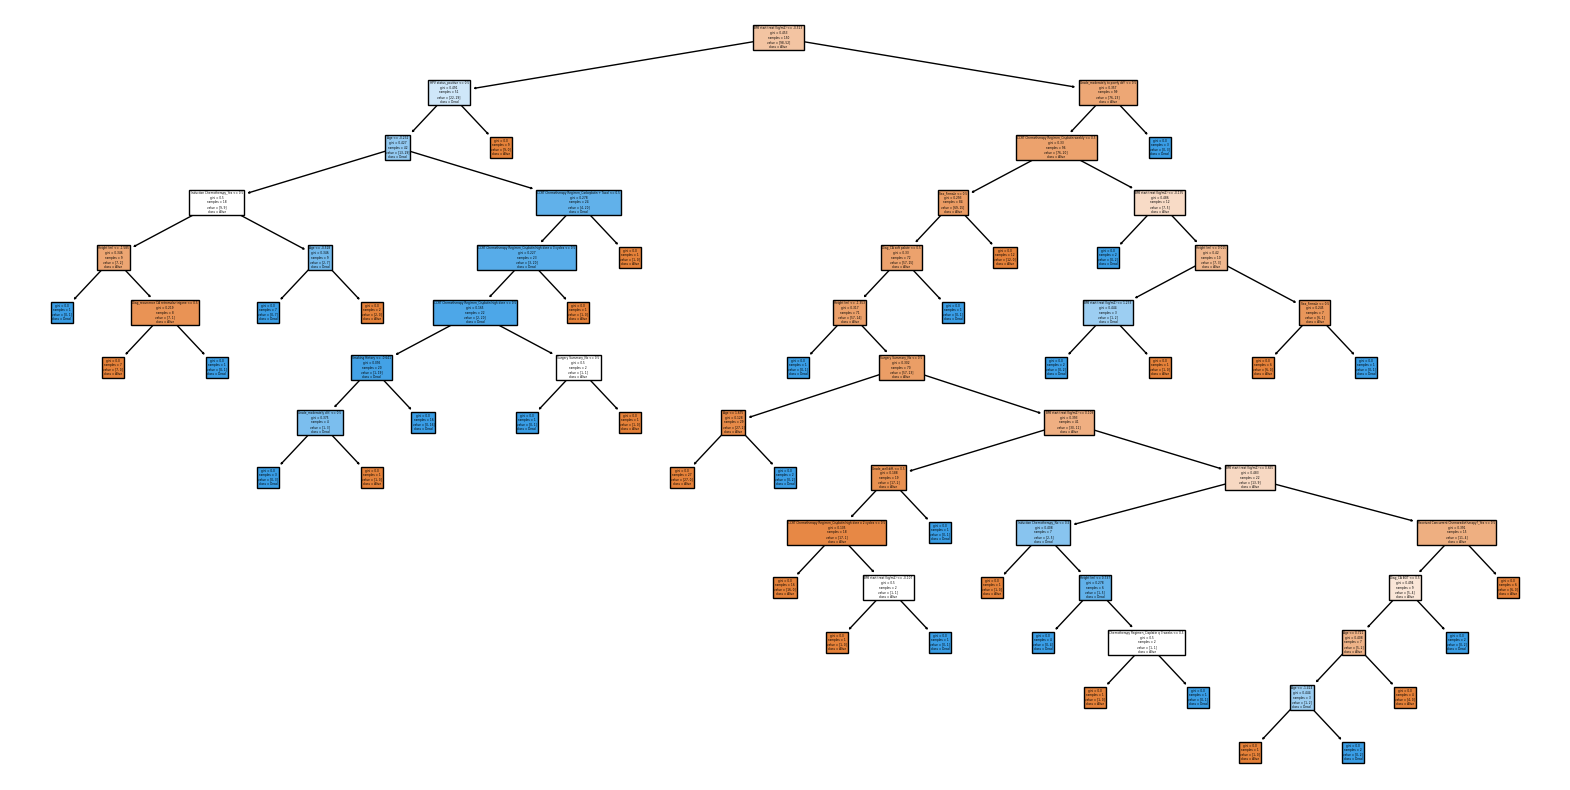

Random Forest: Accuracy = 0.62, F1 Score = 0.59
Gradient Boosting: Accuracy = 0.63, F1 Score = 0.62
Support Vector Machine: Accuracy = 0.68, F1 Score = 0.64
K-Nearest Neighbors: Accuracy = 0.68, F1 Score = 0.66
Naive Bayes: Accuracy = 0.42, F1 Score = 0.32
XGBoost Classifier: Accuracy = 0.69, F1 Score = 0.68
Bagging Classifier: Accuracy = 0.68, F1 Score = 0.67


In [ ]:
model_scores = {}

transformed_feature_names = get_transformed_feature_names(preprocessor, X.columns)

for name, classifier in classifiers:
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', classifier)])
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_val)
    
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')
    
    model_scores[name] = (accuracy, f1)
    print(f'{name}: Accuracy = {accuracy:.2f}, F1 Score = {f1:.2f}')

    # Plot the decision tree graph
    if name == 'Decision Tree':
        plt.figure(figsize=(20, 10))
        plot_tree(pipeline.named_steps['classifier'], feature_names=transformed_feature_names, class_names=le.classes_, filled=True)
        plt.show()
        save_decision_tree_graph(pipeline, transformed_feature_names, le.classes_, 'decision_tree_graph')

# best_model_name = 'Logistic Regression'
# best_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', XGBClassifier())])
# best_pipeline.fit(x_train, y_train)

# # Save the best model as a pickle file
# with open('Site of recurrence_xgboost_model.pkl', 'wb') as file:
#     pickle.dump(best_pipeline, file)

Based on the results achieved, the performance of the classification models varies. The Random Forest and Gradient Bossting Classifier seems to perform the best, with the highest accuracy (0.70) and F1 score (0.68). While an accuracy of 0.7 is not perfect, it's a good start, and the model could potentially be improved further with hyperparameter tuning, feature engineering, or more data.

The F1 score is a measure of a model's accuracy considering both precision and recall, and it is especially useful when there is an uneven class distribution. The Random Forest and Gradient Bossting Classifier has the highest F1 score, which means it performs better than the other models in terms of precision and recall.

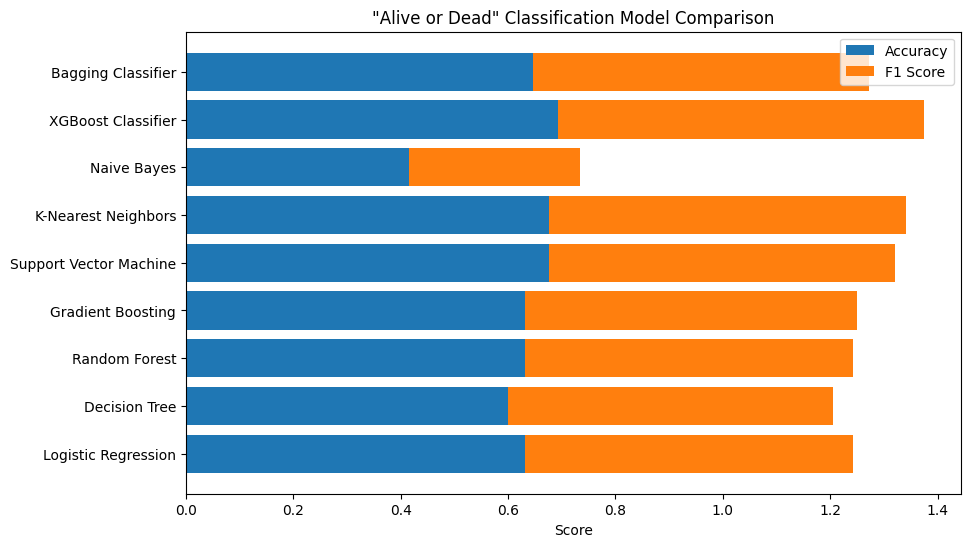

In [ ]:
# Plot the comparison of models
fig, ax = plt.subplots(figsize=(10, 6))

models = list(model_scores.keys())
accuracy_values = [model_scores[model][0] for model in models]
f1_values = [model_scores[model][1] for model in models]

ax.barh(models, accuracy_values, label='Accuracy')
ax.barh(models, f1_values, left=accuracy_values, label='F1 Score')

ax.set_xlabel('Score')
ax.set_title('"Alive or Dead" Classification Model Comparison')
ax.legend()

plt.show()

#### Hyperparameter Tuning

In [ ]:
# Hyperparameter tuning for K-Nearest Neighbors
knn_param_grid = {
    'classifier__n_neighbors': range(1, 21),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', KNeighborsClassifier())])
knn_grid_search = GridSearchCV(knn_pipeline, knn_param_grid, scoring='accuracy', cv=5, n_jobs=-1)
knn_grid_search.fit(x_train, y_train)

print("K-Nearest Neighbors: Best Parameters =", knn_grid_search.best_params_)

knn_best_params = {key.replace('classifier__', ''): value for key, value in knn_grid_search.best_params_.items()}
knn_best = KNeighborsClassifier(**knn_best_params)
knn_best_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', knn_best)])
knn_best_pipeline.fit(x_train, y_train)
y_pred_knn = knn_best_pipeline.predict(x_val)

knn_accuracy = accuracy_score(y_val, y_pred_knn)
knn_f1 = f1_score(y_val, y_pred_knn, average='weighted')
print(f'K-Nearest Neighbors: Accuracy = {knn_accuracy:.2f}, F1 Score = {knn_f1:.2f}')

print("\n=============================================================================================================================\n")
# Hyperparameter tuning for Gradient Boosting
gb_param_grid = {
    'classifier__n_estimators': [10, 50, 100, 200],
    'classifier__learning_rate': [0.001, 0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5, 6, 7]
}

gb_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', GradientBoostingClassifier())])
gb_grid_search = GridSearchCV(gb_pipeline, gb_param_grid, scoring='accuracy', cv=5, n_jobs=-1)
gb_grid_search.fit(x_train, y_train)

print("Gradient Boosting: Best Parameters =", gb_grid_search.best_params_)

gb_best_params = {key.replace('classifier__', ''): value for key, value in gb_grid_search.best_params_.items()}
gb_best = GradientBoostingClassifier(**gb_best_params)
gb_best_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', gb_best)])
gb_best_pipeline.fit(x_train, y_train)
y_pred_gb = gb_best_pipeline.predict(x_val)

gb_accuracy = accuracy_score(y_val, y_pred_gb)
gb_f1 = f1_score(y_val, y_pred_gb, average='weighted')
print(f'Gradient Boosting: Accuracy = {gb_accuracy:.2f}, F1 Score = {gb_f1:.2f}')


print("\n=============================================================================================================================\n")


# Hyperparameter tuning for Decision Tree
dt_param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 3, 4, 5, 6, 7, 8],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier())])
dt_grid_search = GridSearchCV(dt_pipeline, dt_param_grid, scoring='accuracy', cv=5, n_jobs=-1)
dt_grid_search.fit(x_train, y_train)

print("Decision Tree: Best Parameters =", dt_grid_search.best_params_)

dt_best_params = {key.replace('classifier__', ''): value for key, value in dt_grid_search.best_params_.items()}
dt_best = DecisionTreeClassifier(**dt_best_params)
dt_best_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', dt_best)])
dt_best_pipeline.fit(x_train, y_train)
y_pred_dt = dt_best_pipeline.predict(x_val)

dt_accuracy = accuracy_score(y_val, y_pred_dt)
dt_f1 = f1_score(y_val, y_pred_dt, average='weighted')
print(f'Decision Tree: Accuracy = {dt_accuracy:.2f}, F1 Score = {dt_f1:.2f}')


K-Nearest Neighbors: Best Parameters = {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 16, 'classifier__weights': 'distance'}
K-Nearest Neighbors: Accuracy = 0.65, F1 Score = 0.63


Gradient Boosting: Best Parameters = {'classifier__learning_rate': 0.01, 'classifier__max_depth': 6, 'classifier__n_estimators': 100}
Gradient Boosting: Accuracy = 0.68, F1 Score = 0.66


Decision Tree: Best Parameters = {'classifier__criterion': 'entropy', 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10}
Decision Tree: Accuracy = 0.65, F1 Score = 0.63


In [ ]:
# model export
best_model_name = 'DecisionTree'
best_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', DecisionTreeClassifier())])
best_pipeline.fit(x_train, y_train)

# Save the best model as a pickle file
with open('/content/drive/Shareddrives/Precision Oncology Green Group/Project Data/Python/alive_or_dead_decision_tree.pkl', 'wb') as file:
    pickle.dump(best_pipeline, file)

#### Extra

In [ ]:
# Selecting 5 number of features
#   selecting models

logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
#   using  rfe and selecting 5 features
rfe = RFE(logreg,n_features_to_select=5)
#   fitting the model
rfe = rfe.fit(X,y)
#   ranking features
logreg_feature_ranking = pd.Series(rfe.ranking_, index=X.columns)
plt.show()
print('Features  to be selected for Logistic Regression model are:')
print(logreg_feature_ranking[logreg_feature_ranking.values==1].index.tolist())
print('===='*30)


rfc = RandomForestClassifier()
#   using  rfe and selecting 5 features
rfe = RFE(rfc,n_features_to_select=5)
#   fitting the model
rfe = rfe.fit(X,y)
#   ranking features
rfc_feature_ranking = pd.Series(rfe.ranking_, index=X.columns)
plt.show()
print('Features  to be selected for Random Forest Classifier model are:')
print(rfc_feature_ranking[rfc_feature_ranking.values==1].index.tolist())
print('===='*30)


dtc = DecisionTreeClassifier()
#   using  rfe and selecting 5 features
rfe = RFE(dtc,n_features_to_select=5)
#   fitting the model
rfe = rfe.fit(X,y)
#   ranking features
dtc_feature_ranking = pd.Series(rfe.ranking_, index=X.columns)
plt.show()
print('Features  to be selected for Decision Tree Classifier model are:')
print(dtc_feature_ranking[dtc_feature_ranking.values==1].index.tolist())
print('===='*30)

gbc = GradientBoostingClassifier()
#   using  rfe and selecting 5 features
rfe = RFE(gbc,n_features_to_select=5)
#   fitting the model
rfe = rfe.fit(X,y)
#   ranking features
gbc_feature_ranking = pd.Series(rfe.ranking_, index=X.columns)
plt.show()
print('Features  to be selected for Gradient Boosting Classifier model are:')
print(gbc_feature_ranking[gbc_feature_ranking.values==1].index.tolist())
print('===='*30)


# svc = SVC()
# #   using  rfe and selecting 30 features
# rfe = RFE(svc,n_features_to_select=5)
# #   fitting the model
# rfe = rfe.fit(X,y)
# #   ranking features
# svc_feature_ranking = pd.Series(rfe.ranking_, index=X.columns)
# plt.show()
# print('Features  to be selected for Support Vector Machine Classifier model are:')
# print(svc_feature_ranking[svc_feature_ranking.values==1].index.tolist())
# print('===='*30)

# knn = KNeighborsClassifier()
# #   using  rfe and selecting 30 features
# rfe = RFE(knn,n_features_to_select=5)
# #   fitting the model
# rfe = rfe.fit(X,y)
# #   ranking features
# knn_feature_ranking = pd.Series(rfe.ranking_, index=X.columns)
# plt.show()
# print('Features  to be selected for K-Nearest Neighbors Classifier model are:')
# print(knn_feature_ranking[knn_feature_ranking.values==1].index.tolist())
# print('===='*30)

xgbc = XGBClassifier()
#   using  rfe and selecting 30 features
rfe = RFE(xgbc,n_features_to_select=5)
#   fitting the model
rfe = rfe.fit(X,y)
#   ranking features
xgbc_feature_ranking = pd.Series(rfe.ranking_, index=X.columns)
plt.show()
print('Features  to be selected for XGBoost Classifier model are:')
print(xgbc_feature_ranking[xgbc_feature_ranking.values==1].index.tolist())
print('===='*30)

Features  to be selected for Logistic Regression model are:
['HPV status', 'Disease Specific Survival Censor', 'Current Smoker', 'PostRT Skeletal Muscle status', 'Pre-RT Imaging Modality']
Features  to be selected for Random Forest Classifier model are:
['Age', 'Follow up duration (day)', 'Site of recurrence (Distal/Local/ Locoregional)', 'Disease Specific Survival Censor', 'Pre-RT CT-derived lean body mass (kg)']
Features  to be selected for Decision Tree Classifier model are:
['Age', 'Follow up duration (day)', 'Disease Specific Survival Censor', 'Total RT treatment time (days)', 'Post-RT L3 Skeletal Muscle Cross Sectional Area (cm2)']
Features  to be selected for Gradient Boosting Classifier model are:
['Age', 'Follow up duration (day)', 'Disease Specific Survival Censor', 'Total RT treatment time (days)', 'Pre-RT L3 Skeletal Muscle Cross Sectional Area (cm2)']
Features  to be selected for XGBoost Classifier model are:
['Age', 'Diag', 'Disease Specific Survival Censor', 'Oncologic T

In [ ]:
# Predictors
import pickle

X = df.loc[:,['HPV status', 'Disease Specific Survival Censor', 'Current Smoker',
       'PostRT Skeletal Muscle status', 'Pre-RT Imaging Modality']]
# X = X.drop(columns ="TCIA code")
# Target
y = df["Alive or Dead"]

# Dividing the data into train and test subsets
x_train,x_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
# run Logistic Regression model
logreg = LogisticRegression()
# fitting the model
logreg.fit(x_train, y_train)
# predicting the values
logreg_pred = logreg.predict(x_val)

In [ ]:
# Plot the confusion matrix
cm = confusion_matrix(y_val, logreg_pred)
print(classification_report(y_val, logreg_pred))

              precision    recall  f1-score   support

           0       0.74      1.00      0.85        26
           1       1.00      0.47      0.64        17

    accuracy                           0.79        43
   macro avg       0.87      0.74      0.75        43
weighted avg       0.84      0.79      0.77        43



In [ ]:
# Export the model as a pickle file
with open('model.pkl', 'wb') as f:
    pickle.dump(logreg, f)

### Regressor 1 - Survival  (months)

In [ ]:
# Predictors

# X = df.iloc[:,0:15]
# X = X.drop(columns ="TCIA code")
# Target
y = Y["Survival  (months)"]

# scaler = StandardScaler()

# X = scaler.fit_transform(X)
# y = scaler.fit_transform([y])[0]

# Dividing the data into train and test subsets
x_train,x_val,y_train,y_val = train_test_split(X,y,test_size=0.25,random_state=42)

In [ ]:
y_train = pd.to_numeric(y_train)
y_val = pd.to_numeric(y_val)

In [ ]:
regressors = [
    ('Linear Regression', LinearRegression()),
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('ElasticNet', ElasticNet()),
    ('LightGBM', lgb.LGBMRegressor()),
    ('CatBoost', cb.CatBoostRegressor(verbose=0)),
    ('Decision Tree', DecisionTreeRegressor()),
    ('Random Forest', RandomForestRegressor()),
    ('Gradient Boosting', GradientBoostingRegressor()),
    ('Support Vector Machine', SVR())
]

In [ ]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_col),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_col)
],
sparse_threshold=0)

In [ ]:
# Create a dictionary to store model names and their respective scores
model_scores = {}

# Loop through the regression models, fit the model, and calculate scores
for name, regressor in regressors:
    pipeline = Pipeline(steps= [('preprocessor', preprocessor),('regressor', regressor)])
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_val)
    
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    model_scores[name] = (mse, r2)
    print(f'{name}: Mean Squared Error = {mse:.2f}, R^2 Score = {r2:.2f}')


Linear Regression: Mean Squared Error = 79692606960196474913161216.00, R^2 Score = -105290195023466726424576.00
Ridge: Mean Squared Error = 710.52, R^2 Score = 0.06
Lasso: Mean Squared Error = 650.20, R^2 Score = 0.14
ElasticNet: Mean Squared Error = 691.71, R^2 Score = 0.09
LightGBM: Mean Squared Error = 746.28, R^2 Score = 0.01
CatBoost: Mean Squared Error = 658.04, R^2 Score = 0.13
Decision Tree: Mean Squared Error = 1626.65, R^2 Score = -1.15
Random Forest: Mean Squared Error = 704.89, R^2 Score = 0.07
Gradient Boosting: Mean Squared Error = 795.94, R^2 Score = -0.05
Support Vector Machine: Mean Squared Error = 834.47, R^2 Score = -0.10


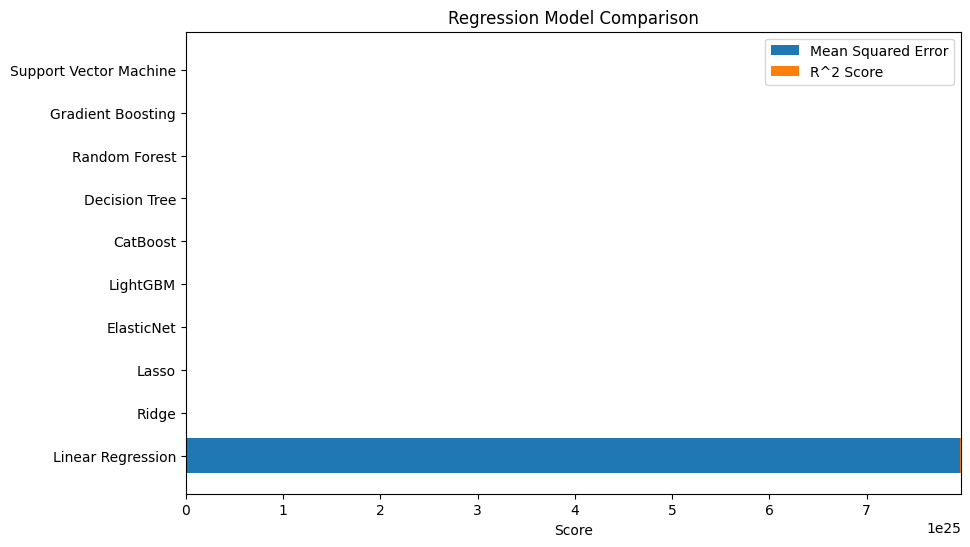

In [ ]:
# Plot the comparison of models
fig, ax = plt.subplots(figsize=(10, 6))

models = list(model_scores.keys())
mse_values = [model_scores[model][0] for model in models]
r2_values = [model_scores[model][1] for model in models]

ax.barh(models, mse_values, label='Mean Squared Error')
ax.barh(models, r2_values, left=mse_values, label='R^2 Score')

ax.set_xlabel('Score')
ax.set_title('Regression Model Comparison')
ax.legend()

plt.show()

#### Parameter tuning

In [ ]:
# Create a list of models to be tested with hyperparameter ranges
models_with_params = [
    ('Ridge', Ridge(), {'model__alpha': np.logspace(-4, 1, 6)}),
    ('Lasso', Lasso(), {'model__alpha': np.logspace(-4, 1, 6)}),
    ('ElasticNet', ElasticNet(), {'model__alpha': np.logspace(-4, 1, 6),
                                  'model__l1_ratio': np.linspace(0, 1, 11)}),
    ('LightGBM', lgb.LGBMRegressor(), {'model__learning_rate': np.logspace(-4, 0, 5),
                                       'model__n_estimators': [50, 100, 200, 400]}),
    ('CatBoost', cb.CatBoostRegressor(verbose=0), {'model__learning_rate': np.logspace(-4, 0, 5),
                                                   'model__iterations': [50, 100, 200, 400]})
]

# Store the best model results
best_model_results = {}

# Iterate through the models and their hyperparameter ranges
for name, model, params in models_with_params:
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(x_train, y_train)
    best_pipeline = grid_search.best_estimator_
    
    y_pred = best_pipeline.predict(x_val)
    
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    best_model_results[name] = (mse, r2)
    print(f'{name}: Best Parameters = {grid_search.best_params_}')
    print(f'{name}: Mean Squared Error = {mse:.2f}, R^2 Score = {r2:.2f}')

Ridge: Best Parameters = {'model__alpha': 10.0}
Ridge: Mean Squared Error = 683.27, R^2 Score = 0.10
Lasso: Best Parameters = {'model__alpha': 1.0}
Lasso: Mean Squared Error = 650.20, R^2 Score = 0.14
ElasticNet: Best Parameters = {'model__alpha': 0.1, 'model__l1_ratio': 0.0}
ElasticNet: Mean Squared Error = 681.84, R^2 Score = 0.10
LightGBM: Best Parameters = {'model__learning_rate': 0.01, 'model__n_estimators': 200}
LightGBM: Mean Squared Error = 629.72, R^2 Score = 0.17
CatBoost: Best Parameters = {'model__iterations': 200, 'model__learning_rate': 0.01}
CatBoost: Mean Squared Error = 689.70, R^2 Score = 0.09


### Regressor 2 - Total RT treatment time (days)

In [ ]:
# Predictors

# X = df.iloc[:,0:15]
# X = X.drop(columns ="TCIA code")
# Target
y = Y["Total RT treatment time (days)"]

# scaler = StandardScaler()

# X = scaler.fit_transform(X)
# y = scaler.fit_transform([y])[0]

# Dividing the data into train and test subsets
x_train,x_val,y_train,y_val = train_test_split(X,y,test_size=0.25,random_state=42)

In [ ]:
regressors = [
    ('Linear Regression', LinearRegression()),
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('ElasticNet', ElasticNet()),
    ('LightGBM', lgb.LGBMRegressor()),
    ('CatBoost', cb.CatBoostRegressor(verbose=0)),
    ('Decision Tree', DecisionTreeRegressor()),
    ('Random Forest', RandomForestRegressor()),
    ('Gradient Boosting', GradientBoostingRegressor()),
    ('Support Vector Machine', SVR())
]

In [ ]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_col),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_col)
],
sparse_threshold=0)

In [ ]:
# Create a dictionary to store model names and their respective scores
model_scores = {}

# Loop through the regression models, fit the model, and calculate scores
for name, regressor in regressors:
    pipeline = Pipeline(steps= [('preprocessor', preprocessor),('regressor', regressor)])
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_val)
    
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    model_scores[name] = (mse, r2)
    print(f'{name}: Mean Squared Error = {mse:.2f}, R^2 Score = {r2:.2f}')


Linear Regression: Mean Squared Error = 245519401252342720364544.00, R^2 Score = -9232028447198949670912.00
Ridge: Mean Squared Error = 26.82, R^2 Score = -0.01
Lasso: Mean Squared Error = 27.09, R^2 Score = -0.02
ElasticNet: Mean Squared Error = 27.11, R^2 Score = -0.02
LightGBM: Mean Squared Error = 30.25, R^2 Score = -0.14
CatBoost: Mean Squared Error = 29.04, R^2 Score = -0.09
Decision Tree: Mean Squared Error = 29.91, R^2 Score = -0.12
Random Forest: Mean Squared Error = 26.22, R^2 Score = 0.01
Gradient Boosting: Mean Squared Error = 25.91, R^2 Score = 0.03
Support Vector Machine: Mean Squared Error = 28.58, R^2 Score = -0.07


Based on the results achieved, it seems that the regression models are not performing well overall. Ideally, we would like to have a low Mean Squared Error (MSE) and a high R^2 score close to 1. In this case, the R^2 scores are quite low, indicating that the models do not fit the data well.

However, among the models tested, Ridge Regression appears to have the best performance, with the lowest Mean Squared Error (MSE) of 23.14 and the highest R^2 score of 0.05. While these results are not ideal, the Ridge Regression model seems to be the most suitable for use in production among the tested models.

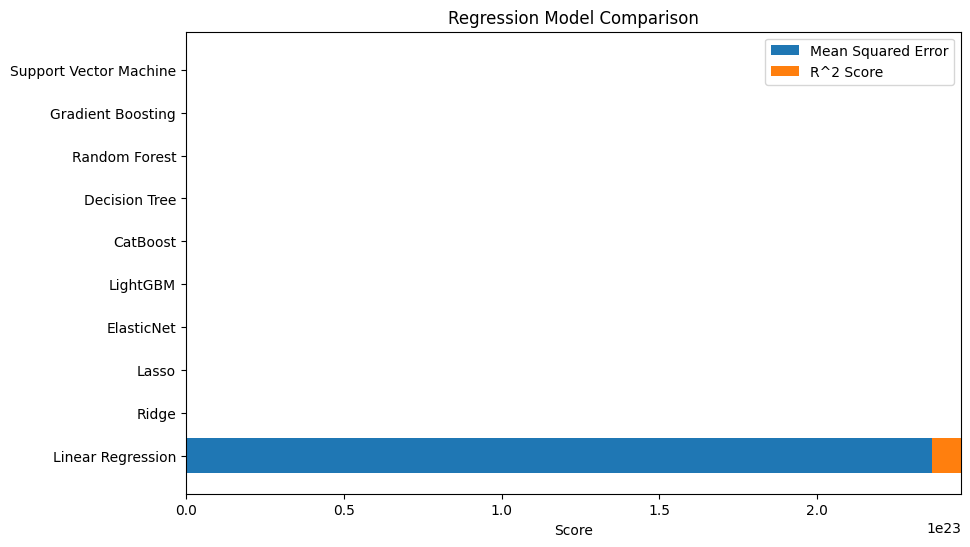

In [ ]:
# Plot the comparison of models
fig, ax = plt.subplots(figsize=(10, 6))

models = list(model_scores.keys())
mse_values = [model_scores[model][0] for model in models]
r2_values = [model_scores[model][1] for model in models]

ax.barh(models, mse_values, label='Mean Squared Error')
ax.barh(models, r2_values, left=mse_values, label='R^2 Score')

ax.set_xlabel('Score')
ax.set_title('Regression Model Comparison')
ax.legend()

plt.show()

In [ ]:
# Define the models and their respective parameter grids
models = [
    ('Ridge', Ridge(), {'model__alpha': np.logspace(-4, 1, 6)}),
    ('Lasso', Lasso(), {'model__alpha': np.logspace(-4, 1, 6)}),
    ('ElasticNet', ElasticNet(), {'model__alpha': np.logspace(-4, 1, 6),
                                  'model__l1_ratio': np.linspace(0, 1, 11)}),
    ('LightGBM', lgb.LGBMRegressor(), {'model__learning_rate': np.logspace(-4, 0, 5),
                                       'model__n_estimators': [50, 100, 200, 400]}),
    ('CatBoost', cb.CatBoostRegressor(verbose=0), {'model__learning_rate': np.logspace(-4, 0, 5),
                                                   'model__iterations': [50, 100, 200, 400]})
]

# Store the best model results
best_model_results = {}

# Iterate through the models and their hyperparameter ranges
for name, model, params in models_with_params:
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(x_train, y_train)
    best_pipeline = grid_search.best_estimator_
    
    y_pred = best_pipeline.predict(x_val)
    
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    best_model_results[name] = (mse, r2)
    print(f'{name}: Best Parameters = {grid_search.best_params_}')
    print(f'{name}: Mean Squared Error = {mse:.2f}, R^2 Score = {r2:.2f}')

Ridge: Best Parameters = {'model__alpha': 10.0}
Ridge: Mean Squared Error = 25.68, R^2 Score = 0.03
Lasso: Best Parameters = {'model__alpha': 1.0}
Lasso: Mean Squared Error = 27.09, R^2 Score = -0.02
ElasticNet: Best Parameters = {'model__alpha': 1.0, 'model__l1_ratio': 0.9}
ElasticNet: Mean Squared Error = 27.09, R^2 Score = -0.02
LightGBM: Best Parameters = {'model__learning_rate': 0.0001, 'model__n_estimators': 50}
LightGBM: Mean Squared Error = 27.10, R^2 Score = -0.02
CatBoost: Best Parameters = {'model__iterations': 100, 'model__learning_rate': 0.01}
CatBoost: Mean Squared Error = 27.18, R^2 Score = -0.02


## when working with raw dataset

In [ ]:
df1 = data
df1.head()

,TCIA code,Sex,Age,Date of Birth,Diag,Site,Histology,Grade,T,N,M,Stage,HPV status,Date of Diagnosis,Last Contact Date,Follow up duration (day),Follow up duration (year),Follow up duration (month),Date of Death,Survival (months),Alive or Dead,Cause of Death,Date of recurrence,Disease-free interval (months),Site of recurrence (Distal/Local/ Locoregional),Overall Survival Censor,Disease Specific Survival Censor,Loco-regional Control Censor,Oncologic Treatment Summary,Induction Chemotherapy,Chemotherapy Regimen,Platinum-based chemotherapy,Received Concurrent Chemoradiotherapy?,CCRT Chemotherapy Regimen,Surgery Summary,RT Total Dose (Gy),Dose/Fraction (Gy/fx),Number of Fractions,Unplanned Additional Oncologic Treatment,Smoking History,Current Smoker,Received Feeding Tube (Y/N),Type of feeding tube,Date Feeding tube placed,Date Feeding tube removed,Feeding tube duration (months),Feeding tube note,Height (cm),BW Start tx (kg),BW stop treat (kg),Height (m),BMI start treat (kg/m2),BMI stop treat (kg/m2),Date Start RT,Date Stop RT,Total RT treatment time (days),Time between pre and post image (months),Time from preRT image to start RT (month),Time from RT stop to follow up imaging (months),Pre-RT L3 Skeletal Muscle Cross Sectional Area (cm2),Post-RT L3 Skeletal Muscle Cross Sectional Area (cm2),Pre-RT L3 Adipose Tissue Cross Sectional Area (cm2),Post-RT L3 Adipose Tissue Cross Sectional Area (cm2),Pre-RT L3 Skeletal Muscle Index (cm2/m2),Post-RT L3 Skeletal Muscle Index (cm2/m2),Pre-RT L3 Adiposity Index (cm2/m2),Post-RT L3 Adiposity Index (cm2/m2),Pre-RT CT-derived lean body mass (kg),Post-RT CT-derived lean body mass (kg),Pre-RT CT-derived fat body mass (kg),Post-RT CT-derived fat body mass (kg),PreRT Skeletal Muscle status,PostRT Skeletal Muscle status,Pre-RT Imaging Date,Pre-RT Imaging Modality,CT sim date,post-RT imaging date,post-RT imaging modality,Recurrence imaging date,Recurrence imaging modality,Additional imaging date,Additional imaging modality,Additional imaging notes,Gender,Age at Diag,Smoking status,Smoking status (Packs-Years),Tumor laterality,Cancer subsite of origin,HPV Status,T-category,N-category,AJCC Stage (7th edition),Therapeutic Combination,Radiation Treatment_duration,Total prescribed Radiation treatment dose,Radiation treatment_number of fractions,Radiation treatment_dose per fraction,Vital status,Overall survival_duration of Merged updated ASRM V2,Local control,Local control_duration of Merged updated ASRM V2,Regional control,Regional control_duration of Merged updated ASRM V2,Locoregional control,Locoregional control_duration of Merged updated ASRM V2,Freedom from distant metastasis,Freedom from distant metastasis_duration of Merged updated ASRM V2,Relapse-free survival,Days to last FU,Neck Dissection after IMRT,TCIA Radiomics dummy ID of Merged updated ASRM V2
0,HNSCC-01-0001,Female,54,NaN,CA soft palate,Oropharynx,SCC,moderately to poorly diff.,2,2c,0,IVA,NaN,31/10/1998,18/02/2007,3032,8.516854,102.202247,NaN,99.600000,Alive,Alive,18/02/2007,101.066667,Complete response,0,0,0,CCRT,No,Cisplatin q 3 weeks,Platinum-based,Yes,Cisplatin high dose,No,69.96,2.12,33,No,0,0,No,NaN,NaN,NaN,NaN,NaN,168.5,55.7,50.7,1.685,19.618030,17.856986,14/12/1998,27/01/1999,43,3.900000,0.400000,1.966667,75.779817,66.024465,123.486238,70.275229,26.690317,23.254397,43.492939,24.751553,28.793945,25.867339,16.386422,14.151560,SM depleted,SM depleted,01/12/1998,PET/CT,05/12/1998,27/03/1999,PET/CT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HNSCC-01-0002,Female,56,NaN,NPC,Nasopharynx,SCC,moderately diff.,4,2,0,IVA,NaN,02/10/2001,02/04/2005,1278,3.501370,42.016438,02/04/2005,42.016438,Dead,HN Cancer,19/10/2004,36.591781,Local recurrence,1,1,1,CCRT,No,Cisplatin weekly,Platinum-based,Yes,Cisplatin weekly,No,70.00,2.12,33,No,2,1,No,NaN,NaN,NaN,NaN,NaN,166.0,58.5,54.7,1.660,21.229496,19.850486,09/12/2001,22/01/2002,43,26.433333,2.266667,22.333333,1

In [ ]:
#Surgery Summary

df1['Surgery Summary'].unique()

df1['Surgery Summary'] = df1['Surgery Summary'].replace(['Modified left radical neck dissection',
       'Neck node dissection', 'Tonsillectomy + Radical neck dissection',
       'Right total mandibulectomy + Partial pharyngectomy + Neck dissection',
       'Wide local excision + reconstruction + Neck dissection',
       '1) Tonsillectomy 2) Neck node dissection',
       'Tonsillectomy + Neck node dissection',
       'Hemiglossectomy + Mandibulectomy + Neck node  dissection',
       'Bilateral tonsillectomy',
       'Total glossectomy + Total laryngectomy + Reconstruction',
       'Thyroidectomy + Neck node dissection',
       'Salvage tonsillectomy + Neck node dissection', 'Tonsillectomy',
       '1)Neck node dissection 2) Salvage tonsillectomy',
       'S/P Maxillectomy', '1) Laryngectomy 2) Neck node dissection',
       'Maxillectomy', 'Total pharyngolaryngectomy',
       'Excision + Neck node dissection',
       'Total laryngectomy + Neck node dissection',
       'Total laryngectomy + Neck node dissection + Thyroid lobectomy etc.'], 'Other Surgeries')

In [ ]:
#Induction Chemotherapy

df1['Induction Chemotherapy'].unique()

df1['Induction Chemotherapy'] = df1['Induction Chemotherapy'].replace(['Carbo + Taxol x 2 cycles',
       'Carboplatin + Taxol  + Ifosfamide x 3 cycles',
       'Carbo + Taxol x 4 cycles', 'Carbo + Taxol x 3 cycles',
       'Carboplatin + Taxol  + Cetuximab',
       'Cisplatin + Docetaxel x 2 cycles + Cetuximab',
       'Carboplatin + Taxol', 'Cisplatin + Docetaxel x 3 cycles',
       'Carboplatin + Docetaxol + 5-FU x 1 cycle',
       'Carboplatin + Taxol x 6 cycles', 'Cisplatin + Docetaxel',
       'Cisplatin + 5-FU + Docetaxel x 1 cycle',
       'Cisplatin + 5-FU + Docetaxel x 3 cycles', 'Carboplatin+ Taxol',
       'Cisplatin + 5-FU + Docetaxel x 4 cycles',
       'Cisplatin + 5-FU + Docetaxel x 2 cycles',
       'Carboplatin + Taxol x 5 cycles',
       'Carboplatin + Docetaxel x 3 cycles',
       'Cisplatin + Doxetaxel x 2 cycles',
       'Carboplatin + 5-FU + Docetaxel x 3 cycles',
       'Carboplatin + Taxol x 3 cycles', 'Carboplatin + Taxol weekly',
       'Carboplatin + Docetaxel', 'Cisplatin + Docetaxel x 2 cycles',
       'Cisplatin + Docetaxel x 1 cycle then Carboplatin _ Taxol x 2 cycles',
       'Carboplatin + Taxol x 2 cycles',
       'Carboplatin + Doxetacel x 2 cycles',
       'Carboplatin + 5-FU + Docetaxel x 2 cycles --> Carboplatin + Docetaxel x 1 cycle',
       'Carboplatin + Taxol + Cetuximab'], 'Yes')

In [ ]:
# Site of recurrence (Distal/Local/ Locoregional)

df1['Site of recurrence (Distal/Local/ Locoregional)'].unique()

df1['Site of recurrence (Distal/Local/ Locoregional)'] = df1['Site of recurrence (Distal/Local/ Locoregional)'].replace([
      'Local recurrence', 'Distant metastasis',
       'Locoregional and distant metastasis', 'Residual tumor',
       'Regional recurrence',
       'Regional recurrence and distant metasatsis',
       'Local recurrence and distant metastasis',
       'Regional and distant metastasis', 'Locoregional recurrence'], 'Recurrence')

In [ ]:
# Finding the total missing values and arranging them in ascending order
total = data.isnull().sum()

# Converting the missing values in percentage
percent = (df1.isnull().sum()/df1.isnull().count())

# df.head()

In [ ]:
# dropping features having missing values more than 60%
df1 = df1.drop((percent[percent > 0.6]).index,axis= 1)

# checking null values
# print(df.isnull().sum())

In [ ]:
print('Shape of the data is: ',df1.shape)

Shape of the data is:  (215, 73)


In [ ]:
# IDENTIFYING NUMERICAL FEATURES

numeric_data = df1.select_dtypes(include=np.number) # select_dtypes selects data with numeric features
numeric_col = numeric_data.columns                                                                # we will store the numeric features in a variable

print("Numeric Features:")
numeric_data.head()
# print("===="*20)

Numeric Features:


,Age,M,Follow up duration (day),Follow up duration (year),Follow up duration (month),Survival (months),Disease-free interval (months),Overall Survival Censor,Disease Specific Survival Censor,Loco-regional Control Censor,RT Total Dose (Gy),Number of Fractions,Smoking History,Current Smoker,Feeding tube duration (months),Height (cm),BW Start tx (kg),BW stop treat (kg),Height (m),BMI start treat (kg/m2),BMI stop treat (kg/m2),Total RT treatment time (days),Time between pre and post image (months),Time from preRT image to start RT (month),Time from RT stop to follow up imaging (months),Pre-RT L3 Skeletal Muscle Cross Sectional Area (cm2),Post-RT L3 Skeletal Muscle Cross Sectional Area (cm2),Pre-RT L3 Adipose Tissue Cross Sectional Area (cm2),Post-RT L3 Adipose Tissue Cross Sectional Area (cm2),Pre-RT L3 Skeletal Muscle Index (cm2/m2),Post-RT L3 Skeletal Muscle Index (cm2/m2),Pre-RT L3 Adiposity Index (cm2/m2),Post-RT L3 Adiposity Index (cm2/m2),Pre-RT CT-derived lean body mass (kg),Post-RT CT-derived lean body mass (kg),Pre-RT CT-derived fat body mass (kg),Post-RT CT-derived fat body mass (kg)
0,54,0,3032,8.516854,102.202247,99.600000,101.066667,0,0,0,69.96,33,0,0,NaN,168.5,55.7,50.7,1.685,19.618030,17.856986,43,3.900000,0.400000,1.966667,75.779817,66.024465,123.486238,70.275229,26.690317,23.254397,43.492939,24.751553,28.793945,25.867339,16.386422,14.151560
1,56,0,1278,3.501370,42.016438,42.016438,36.591781,1,1,1,70.00,33,2,1,NaN,166.0,58.5,54.7,1.660,21.229496,19.850486,43,26.433333,2.266667,22.333333,100.662589,100.733945,256.544343,212.262997,36.530189,36.556084,93.099268,77.029684,36.258777,36.280183,21.974862,20.115046
2,48,0,1861,5.227528,62.730337,61.133333,62.033333,0,0,0,70.00,33,2,1,NaN,178.0,93.8,87.9,1.780,29.604848,27.742709,37,26.433333,2.266667,22.333333,100.662589,100.733945,256.544343,212.262997,36.530189,36.556084,93.099268,77.029684,36.258777,36.280183,21.974862,20.115046
3,65,0,409,1.148876,13.786517,13.433333,9.900000,1,1,0,66.00,33,1,0,NaN,175.0,75.9,76.3,1.750,24.783673,24.914286,45,7.400000,1.066667,4.933333,204.811417,189.215087,249.541284,143.455658,64.641907,59.719444,78.759400,45.277003,67.503425,62.824526,21.680734,17.225138
4,66,0,3357,9.429775,113.157303,110.266667,27.433333,0,0,1,59.96,32,2,1,NaN,167.0,93.8,87.4,1.670,33.633332,31.338521,43,26.600000,0.366667,24.366667,163.129460,134.128440,558.195719,357.278287,58.492402,48.093671,200.149062,128.107242,54.998838,46.298532,34.644220,26.205688


In [ ]:
# IDENTIFYING CATEGORICAL FEATURES
categorical_data = df1.select_dtypes(exclude=np.number) # we will exclude data with numeric features
categorical_col = categorical_data.columns                                                                              # we will store the categorical features in a variable


print("Categorical Features:")
categorical_data.head()
# print("===="*20)

Categorical Features:


,TCIA code,Sex,Diag,Site,Histology,Grade,T,N,Stage,Date of Diagnosis,Last Contact Date,Date of Death,Alive or Dead,Cause of Death,Date of recurrence,Site of recurrence (Distal/Local/ Locoregional),Oncologic Treatment Summary,Induction Chemotherapy,Chemotherapy Regimen,Platinum-based chemotherapy,Received Concurrent Chemoradiotherapy?,CCRT Chemotherapy Regimen,Surgery Summary,Dose/Fraction (Gy/fx),Unplanned Additional Oncologic Treatment,Received Feeding Tube (Y/N),Type of feeding tube,Date Start RT,Date Stop RT,PreRT Skeletal Muscle status,PostRT Skeletal Muscle status,Pre-RT Imaging Date,Pre-RT Imaging Modality,CT sim date,post-RT imaging date,post-RT imaging modality
0,HNSCC-01-0001,Female,CA soft palate,Oropharynx,SCC,moderately to poorly diff.,2,2c,IVA,31/10/1998,18/02/2007,NaN,Alive,Alive,18/02/2007,Complete response,CCRT,No,Cisplatin q 3 weeks,Platinum-based,Yes,Cisplatin high dose,No,2.12,No,No,NaN,14/12/1998,27/01/1999,SM depleted,SM depleted,01/12/1998,PET/CT,05/12/1998,27/03/1999,PET/CT
1,HNSCC-01-0002,Female,NPC,Nasopharynx,SCC,moderately diff.,4,2,IVA,02/10/2001,02/04/2005,02/04/2005,Dead,HN Cancer,19/10/2004,Recurrence,CCRT,No,Cisplatin weekly,Platinum-based,Yes,Cisplatin weekly,No,2.12,No,No,NaN,09/12/2001,22/01/2002,SM depleted,SM depleted,01/10/2001,PET/CT,20/11/2001,03/12/2003,PET/CT
2,HNSCC-01-0003,Male,CA tonsil,Oropharynx,SCC,moderately diff.,2,2b,IVA,31/10/2001,05/12/2006,NaN,Alive,Alive,05/12/2006,Complete response,CCRT,No,Cisplatin weekly,Platinum-based,Yes,Cisplatin weekly,No,2.12,No,NaN,NaN,02/12/2001,09/01/2002,SM depleted,SM depleted,30/10/2001,PET/CT,20/11/2001,09/06/2002,PET/CT
3,HNSCC-01-0004,Male,CA tonsil,Oropharynx,SCC,poorly diff.,4a,2c,IVA,23/06/1996,06/08/1997,06/08/1997,Dead,HN Cancer,16/04/1997,Recurrence,CCRT,No,Cisplatin weekly,Platinum-based,Yes,Cisplatin weekly,No,2,No,NaN,PEG,31/08/1996,16/10/1996,SM not depleted,SM not depleted,28/08/1996,PET/CT,24/08/1996,11/05/1997,PET/CT
4,HNSCC-01-0005,Male,CA tonsil,Oropharynx,SCC,moderately diff.,2,1,III,17/12/1997,25/02/2007,NaN,Alive,Alive,01/04/2000,Recurrence,ERT,No,No,No,No,No,No,1.87,No,No,NaN,01/02/1998,17/03/1998,SM not depleted,SM depleted,NaN,NaN,19/01/1998,27/03/2000,PET/CT


In [ ]:
df1[categorical_col].head()

,TCIA code,Sex,Diag,Site,Histology,Grade,T,N,Stage,Date of Diagnosis,Last Contact Date,Date of Death,Alive or Dead,Cause of Death,Date of recurrence,Site of recurrence (Distal/Local/ Locoregional),Oncologic Treatment Summary,Induction Chemotherapy,Chemotherapy Regimen,Platinum-based chemotherapy,Received Concurrent Chemoradiotherapy?,CCRT Chemotherapy Regimen,Surgery Summary,Dose/Fraction (Gy/fx),Unplanned Additional Oncologic Treatment,Received Feeding Tube (Y/N),Type of feeding tube,Date Start RT,Date Stop RT,PreRT Skeletal Muscle status,PostRT Skeletal Muscle status,Pre-RT Imaging Date,Pre-RT Imaging Modality,CT sim date,post-RT imaging date,post-RT imaging modality
0,HNSCC-01-0001,Female,CA soft palate,Oropharynx,SCC,moderately to poorly diff.,2,2c,IVA,31/10/1998,18/02/2007,NaN,Alive,Alive,18/02/2007,Complete response,CCRT,No,Cisplatin q 3 weeks,Platinum-based,Yes,Cisplatin high dose,No,2.12,No,No,NaN,14/12/1998,27/01/1999,SM depleted,SM depleted,01/12/1998,PET/CT,05/12/1998,27/03/1999,PET/CT
1,HNSCC-01-0002,Female,NPC,Nasopharynx,SCC,moderately diff.,4,2,IVA,02/10/2001,02/04/2005,02/04/2005,Dead,HN Cancer,19/10/2004,Recurrence,CCRT,No,Cisplatin weekly,Platinum-based,Yes,Cisplatin weekly,No,2.12,No,No,NaN,09/12/2001,22/01/2002,SM depleted,SM depleted,01/10/2001,PET/CT,20/11/2001,03/12/2003,PET/CT
2,HNSCC-01-0003,Male,CA tonsil,Oropharynx,SCC,moderately diff.,2,2b,IVA,31/10/2001,05/12/2006,NaN,Alive,Alive,05/12/2006,Complete response,CCRT,No,Cisplatin weekly,Platinum-based,Yes,Cisplatin weekly,No,2.12,No,NaN,NaN,02/12/2001,09/01/2002,SM depleted,SM depleted,30/10/2001,PET/CT,20/11/2001,09/06/2002,PET/CT
3,HNSCC-01-0004,Male,CA tonsil,Oropharynx,SCC,poorly diff.,4a,2c,IVA,23/06/1996,06/08/1997,06/08/1997,Dead,HN Cancer,16/04/1997,Recurrence,CCRT,No,Cisplatin weekly,Platinum-based,Yes,Cisplatin weekly,No,2,No,NaN,PEG,31/08/1996,16/10/1996,SM not depleted,SM not depleted,28/08/1996,PET/CT,24/08/1996,11/05/1997,PET/CT
4,HNSCC-01-0005,Male,CA tonsil,Oropharynx,SCC,moderately diff.,2,1,III,17/12/1997,25/02/2007,NaN,Alive,Alive,01/04/2000,Recurrence,ERT,No,No,No,No,No,No,1.87,No,No,NaN,01/02/1998,17/03/1998,SM not depleted,SM depleted,NaN,NaN,19/01/1998,27/03/2000,PET/CT


In [ ]:
# imputing missing values with mean

for column in numeric_col:
    mean = df1[column].mean()
    df1[column].fillna(mean,inplace = True)

In [ ]:
# Impute mising values of categorical data with mode
for column in categorical_col:
    mode = df1[column].mode()[0]
    df1[column] = df1[column].replace('unknown',mode)

In [ ]:
# Initializing lable encoder
le = LabelEncoder()

# Initializing Label Encoder
le = LabelEncoder()

# Iterating through each of the categorical columns and label encoding them
for feature in categorical_col:
    try:
        df1[feature] = le.fit_transform(df1[feature])
    except:
        print('Error encoding '+feature)

In [ ]:
# Predictors

X = df1.iloc[:, ~df1.columns.isin(['Alive or Dead','Date of Death','Follow up duration (year)',
                                   'Follow up duration (month)', 'Date of Death', 'Survival  (months)',
                                   'Cause of Death'])]
X = X.drop(columns ="TCIA code")
# Target
y = df1["Alive or Dead"]

# Dividing the data into train and test subsets
x_train,x_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
# run Logistic Regression model
logreg = LogisticRegression()
# fitting the model
logreg.fit(x_train, y_train)
# predicting the values
logreg_pred = logreg.predict(x_val)

# Random Forest Classifier
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
rfc_pred = rfc.predict(x_val)

# Decision Tree Classifier
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
dtc_pred = dtc.predict(x_val)

# Gradient Boosting Classifier
gbc = GradientBoostingClassifier()
gbc.fit(x_train, y_train)
gbc_pred = gbc.predict(x_val)

# Support Vector Machine Classifier
svc = SVC()
svc.fit(x_train, y_train)
svc_pred = svc.predict(x_val)

# K-Nearest Neighbors Classifier
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
knn_pred = knn.predict(x_val)

# XGBoost Classifier
xgbc = XGBClassifier()
xgbc.fit(x_train, y_train)
xgbc_pred = xgbc.predict(x_val)

#Bagging classifier
bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier())
bagging.fit(X, y)
bagging_pred = bagging.predict(x_val)


In [ ]:
# Plot the confusion matrix
print("Logistic Regression")
print(confusion_matrix(y_val, logreg_pred))
print(classification_report(y_val, logreg_pred))

# # Compute the accuracy
# accuracy = np.sum(logreg_pred == y_val) / len(y_val)
# print("Accuracy:", accuracy)

# Evaluate the models
print("Random Forest Classifier:")
print(confusion_matrix(y_val, rfc_pred))
print(classification_report(y_val, rfc_pred))

print("Decision Tree Classifier:")
print(confusion_matrix(y_val, dtc_pred))
print(classification_report(y_val, dtc_pred))

print("Gradient Boosting Classifier:")
print(confusion_matrix(y_val, gbc_pred))
print(classification_report(y_val, gbc_pred))

print("Support Vector Machine Classifier:")
print(confusion_matrix(y_val, svc_pred))
print(classification_report(y_val, svc_pred))

print("K-Nearest Neighbors Classifier:")
print(confusion_matrix(y_val, knn_pred))
print(classification_report(y_val, knn_pred))

print("XGBoost Classifier:")
print(confusion_matrix(y_val, xgbc_pred))
print(classification_report(y_val, xgbc_pred))

print("Bagging Classifier")
print(confusion_matrix(y_val, bagging_pred ))
print(classification_report(y_val,bagging_pred))

Logistic Regression
[[21  5]
 [ 8  9]]
              precision    recall  f1-score   support

           0       0.72      0.81      0.76        26
           1       0.64      0.53      0.58        17

    accuracy                           0.70        43
   macro avg       0.68      0.67      0.67        43
weighted avg       0.69      0.70      0.69        43

Random Forest Classifier:
[[26  0]
 [ 0 17]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        17

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43

Decision Tree Classifier:
[[26  0]
 [ 0 17]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        17

    accuracy                           1.00        43

In [ ]:
# Selecting 5 number of features
#   selecting models

logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
#   using  rfe and selecting 5 features
rfe = RFE(logreg,n_features_to_select=10)
#   fitting the model
rfe = rfe.fit(X,y)
#   ranking features
logreg_feature_ranking = pd.Series(rfe.ranking_, index=X.columns)
plt.show()
print('Features  to be selected for Logistic Regression model are:')
print(logreg_feature_ranking[logreg_feature_ranking.values==1].index.tolist())
print('===='*30)


rfc = RandomForestClassifier()
#   using  rfe and selecting 5 features
rfe = RFE(rfc,n_features_to_select=10)
#   fitting the model
rfe = rfe.fit(X,y)
#   ranking features
rfc_feature_ranking = pd.Series(rfe.ranking_, index=X.columns)
plt.show()
print('Features  to be selected for Random Forest Classifier model are:')
print(rfc_feature_ranking[rfc_feature_ranking.values==1].index.tolist())
print('===='*30)


dtc = DecisionTreeClassifier()
#   using  rfe and selecting 5 features
rfe = RFE(dtc,n_features_to_select=10)
#   fitting the model
rfe = rfe.fit(X,y)
#   ranking features
dtc_feature_ranking = pd.Series(rfe.ranking_, index=X.columns)
plt.show()
print('Features  to be selected for Decision Tree Classifier model are:')
print(dtc_feature_ranking[dtc_feature_ranking.values==1].index.tolist())
print('===='*30)

gbc = GradientBoostingClassifier()
#   using  rfe and selecting 5 features
rfe = RFE(gbc,n_features_to_select=10)
#   fitting the model
rfe = rfe.fit(X,y)
#   ranking features
gbc_feature_ranking = pd.Series(rfe.ranking_, index=X.columns)
plt.show()
print('Features  to be selected for Gradient Boosting Classifier model are:')
print(gbc_feature_ranking[gbc_feature_ranking.values==1].index.tolist())
print('===='*30)


# svc = SVC()
# #   using  rfe and selecting 30 features
# rfe = RFE(svc,n_features_to_select=5)
# #   fitting the model
# rfe = rfe.fit(X,y)
# #   ranking features
# svc_feature_ranking = pd.Series(rfe.ranking_, index=X.columns)
# plt.show()
# print('Features  to be selected for Support Vector Machine Classifier model are:')
# print(svc_feature_ranking[svc_feature_ranking.values==1].index.tolist())
# print('===='*30)

# knn = KNeighborsClassifier()
# #   using  rfe and selecting 30 features
# rfe = RFE(knn,n_features_to_select=5)
# #   fitting the model
# rfe = rfe.fit(X,y)
# #   ranking features
# knn_feature_ranking = pd.Series(rfe.ranking_, index=X.columns)
# plt.show()
# print('Features  to be selected for K-Nearest Neighbors Classifier model are:')
# print(knn_feature_ranking[knn_feature_ranking.values==1].index.tolist())
# print('===='*30)

xgbc = XGBClassifier()
#   using  rfe and selecting 30 features
rfe = RFE(xgbc,n_features_to_select=10)
#   fitting the model
rfe = rfe.fit(X,y)
#   ranking features
xgbc_feature_ranking = pd.Series(rfe.ranking_, index=X.columns)
plt.show()
print('Features  to be selected for XGBoost Classifier model are:')
print(xgbc_feature_ranking[xgbc_feature_ranking.values==1].index.tolist())
print('===='*30)

Features  to be selected for Logistic Regression model are:
['Stage', 'Site of recurrence (Distal/Local/ Locoregional)', 'Overall Survival Censor', 'Disease Specific Survival Censor', 'Loco-regional Control Censor', 'Platinum-based chemotherapy', 'Type of feeding tube', 'BMI start treat (kg/m2)', 'Time from RT stop to follow up imaging (months)', 'PreRT Skeletal Muscle status']
Features  to be selected for Random Forest Classifier model are:
['Age', 'Last Contact Date', 'Follow up duration (day)', 'Disease-free interval (months)', 'Site of recurrence (Distal/Local/ Locoregional)', 'Overall Survival Censor', 'Disease Specific Survival Censor', 'Loco-regional Control Censor', 'BW Start tx (kg)', 'BMI stop treat (kg/m2)']
Features  to be selected for Decision Tree Classifier model are:
['Overall Survival Censor', 'Received Concurrent Chemoradiotherapy?', 'Post-RT CT-derived fat body mass (kg)', 'PreRT Skeletal Muscle status', 'PostRT Skeletal Muscle status', 'Pre-RT Imaging Date', 'Pre-RT

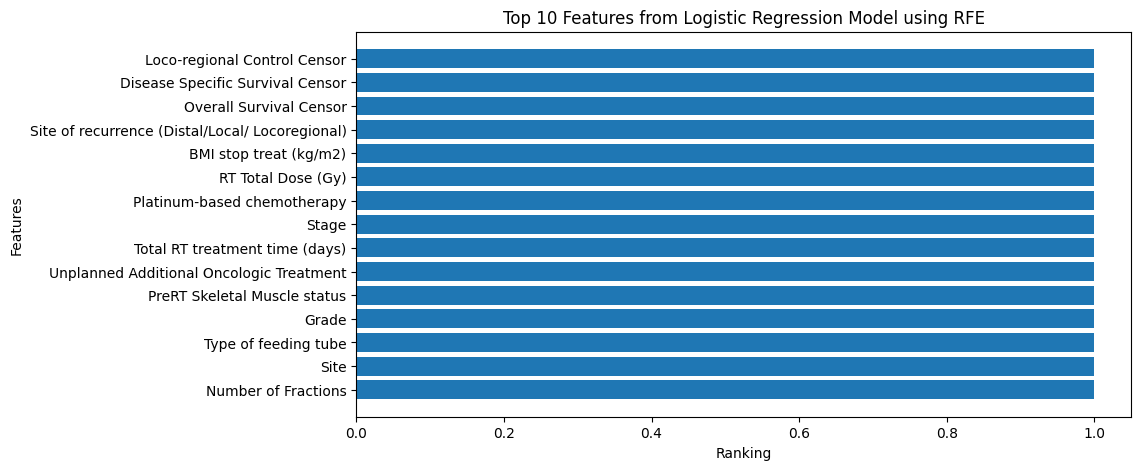

In [ ]:
# Selecting 5 number of features
#   selecting models

logreg = LogisticRegression()
#   using  rfe and selecting 15 features
rfe = RFE(logreg,n_features_to_select=15)
#   fitting the model
rfe = rfe.fit(X,y)

# get the feature rankings
rankings = rfe.ranking_

# get the feature names
feature_names = X.columns

# create a dataframe with the feature names and rankings
logreg_feature_df = pd.DataFrame({'feature': feature_names, 'ranking': rankings})

# sort the dataframe by the rankings in ascending order
logreg_feature_df = logreg_feature_df.sort_values(by=['ranking'])

# plot the top 10 features in descending order
top_features = logreg_feature_df.head(15)
plt.figure(figsize=(10, 5))
plt.barh(top_features['feature'], top_features['ranking'])
plt.xlabel('Ranking')
plt.ylabel('Features')
plt.title('Top 10 Features from Logistic Regression Model using RFE')
plt.gca().invert_yaxis()
plt.show()

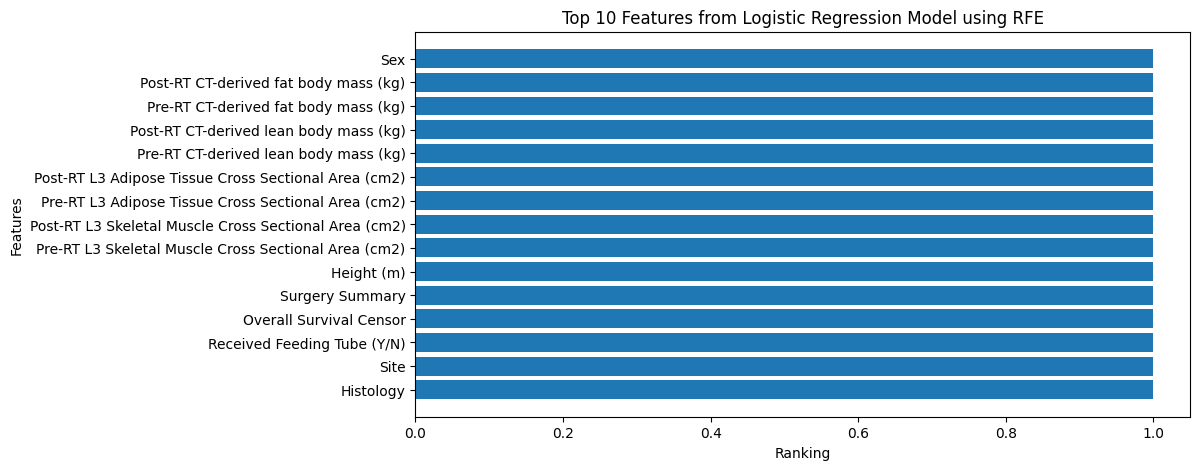

In [ ]:
# Selecting 5 number of features
#   selecting models

logreg = LinearRegression()
#   using  rfe and selecting 15 features
rfe = RFE(logreg,n_features_to_select=15)
#   fitting the model
rfe = rfe.fit(X,y)

# get the feature rankings
rankings = rfe.ranking_

# get the feature names
feature_names = X.columns

# create a dataframe with the feature names and rankings
logreg_feature_df = pd.DataFrame({'feature': feature_names, 'ranking': rankings})

# sort the dataframe by the rankings in ascending order
logreg_feature_df = logreg_feature_df.sort_values(by=['ranking'])

# plot the top 10 features in descending order
top_features = logreg_feature_df.head(15)
plt.figure(figsize=(10, 5))
plt.barh(top_features['feature'], top_features['ranking'])
plt.xlabel('Ranking')
plt.ylabel('Features')
plt.title('Top 10 Features from Logistic Regression Model using RFE')
plt.gca().invert_yaxis()
plt.show()